# RoNIN Dataset Explorer

In [2]:
import json
import pprint
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
import scipy
from scipy.fft import fft, fftfreq, ifft

In [3]:
# Define paths
data_dir = Path("/data/imu-ml-security-project/Data")
archive_name = "a000_1"
info_fname = "info.json"
data_fname = "data.hdf5"

archive_path = data_dir / archive_name

In [4]:
# Load info
with open(archive_path / info_fname) as file:
    archive_info = json.load(file)

pprint.pp(archive_info)

{'tango_reference_time': 18224109457042.0,
 'type': 'annotated',
 'imu_init_gyro_bias': [0.010544000000000001, 0.003433000000000002, 0.009857],
 'grv_ori_error': 3.5197853858138233,
 'imu_acce_scale': [0.9985354317521722, 0.9970119626905871, 0.9979750820973968],
 'date': '01/08/19',
 'start_frame': 5269,
 'imu_end_gyro_bias': [0.010498, 0.003464, 0.009644],
 'align_tango_to_body': [0.5465909317529961,
                         0.5052413139448327,
                         0.4728726629115426,
                         -0.4715517073234252],
 'imu_reference_time': 20994527127022.0,
 'start_calibration': [0.0, 0.99999929, -0.00119368, 0.0],
 'ekf_ori_error': 2.5344151322129282,
 'imu_acce_bias': [-0.09624440822445081,
                   -0.013012258499465551,
                   0.023359359798465342],
 'gyro_integration_error': 3.7698274471572826,
 'device': 'asus5',
 'length': 338.04500006886883,
 'imu_time_offset': 0.028087206665077247,
 'end_calibration': [0.0, 0.99997635, 0.00687733, 0.0]}

In [5]:
# Load h5 file
# Copy into memory for later use
with h5py.File(archive_path / data_fname) as file:
    time = np.copy(file["synced/time"])
    gyro = np.copy(file["synced/gyro"])
    accel = np.copy(file["synced/acce"])
    tango_pos = np.copy(file["pose/tango_pos"])
    tango_ort = np.copy(file["pose/tango_ori"])

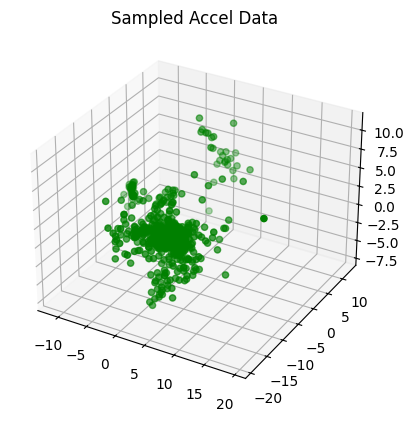

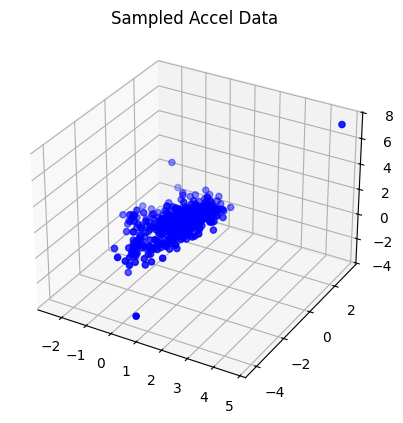

In [6]:
# Plot data

index_range = -1
index_step = 100

# ax.scatter(accel[:index_range, 0], accel[:index_range, 1], zs=accel[:index_range, 2])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(accel[:index_range:index_step, 0], accel[:index_range:index_step, 1], accel[:index_range:index_step, 2], c='g')
ax.set_title("Sampled Accel Data")
plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(gyro[:index_range:index_step, 0], gyro[:index_range:index_step, 1], gyro[:index_range:index_step, 2], c='b')
ax.set_title("Sampled Accel Data")
plt.show()

Single "dataframe" -> Single timestep from synced data

In [7]:
synced_df = pd.DataFrame(
    {
        "time": time[:],
        "gyro_x": gyro[:, 0],
        "gyro_y": gyro[:, 1],
        "gyro_z": gyro[:, 2],
        "accel_x": accel[:, 0],
        "accel_y": accel[:, 1],
        "accel_z": accel[:, 2]
    }
)

print(f"Constructed DF with shape: {synced_df.shape}")

Constructed DF with shape: (67610, 7)


In [8]:
synced_df.head()

,time,gyro_x,gyro_y,gyro_z,accel_x,accel_y,accel_z
0,21066.512851,-0.037365,-0.024461,-0.013006,-9.700169,0.471337,-0.441863
1,21066.517851,-0.031282,-0.023089,-0.015687,-9.698935,0.473029,-0.444046
2,21066.522851,-0.022133,-0.015208,-0.015821,-9.687126,0.468072,-0.453906
3,21066.527851,-0.017850,-0.006523,-0.019232,-9.691151,0.468536,-0.463545
4,21066.532851,-0.013145,-0.003094,-0.019872,-9.716065,0.461727,-0.427714


Compute dataset statistics

In [9]:
# Compute statistics on datasets
gyro_var = [np.var(gyro[:,i]) for i in range(3)]
accel_var = [np.var(accel[:,i]) for i in range(3)]

gyro_std = [np.std(gyro[:,i]) for i in range(3)]
accel_std = [np.std(accel[:,i]) for i in range(3)]

gyro_mean = [np.mean(gyro[:,i]) for i in range(3)]
accel_mean = [np.mean(accel[:,i]) for i in range(3)]

# print(f"Gyro Data:\n|var|\t|{gyro_var:.2f}|\n|std|\t{gyro_std}")
# print(f"Accel Data:\n|var|\t|{accel_var}|\n|std|\t{accel_std}")

def printStats(name, mean, var, std):
    print(f"{name} Data Statistics")
    print("=========================\n")
    print("\t\tx\t\ty\t\tz")
    print(f"mean\t\t{mean[0]:.2f}\t\t{mean[1]:.2f}\t\t{mean[2]:.2f}")
    print(f"var\t\t{var[0]:.2f}\t\t{var[1]:.2f}\t\t{var[2]:.2f}")
    print(f"std\t\t{std[0]:.2f}\t\t{std[1]:.2f}\t\t{std[2]:.2f}")
    print("=========================\n")

printStats("Gyro", gyro_mean, gyro_var, gyro_std)
printStats("Accel", accel_mean, accel_var, accel_std)

Gyro Data Statistics

		x		y		z
mean		0.02		0.03		-0.04
var		0.51		0.90		0.49
std		0.72		0.95		0.70

Accel Data Statistics

		x		y		z
mean		1.10		-8.24		0.35
var		14.28		22.58		4.57
std		3.78		4.75		2.14



Frequency analysis of datasets

In [10]:
sample_rate = 1.0 / ((time[-1]-time[0])/time.shape[-1])
print(f"Sampling Rate: {sample_rate} Hz")

Sampling Rate: 200.00295814529434 Hz


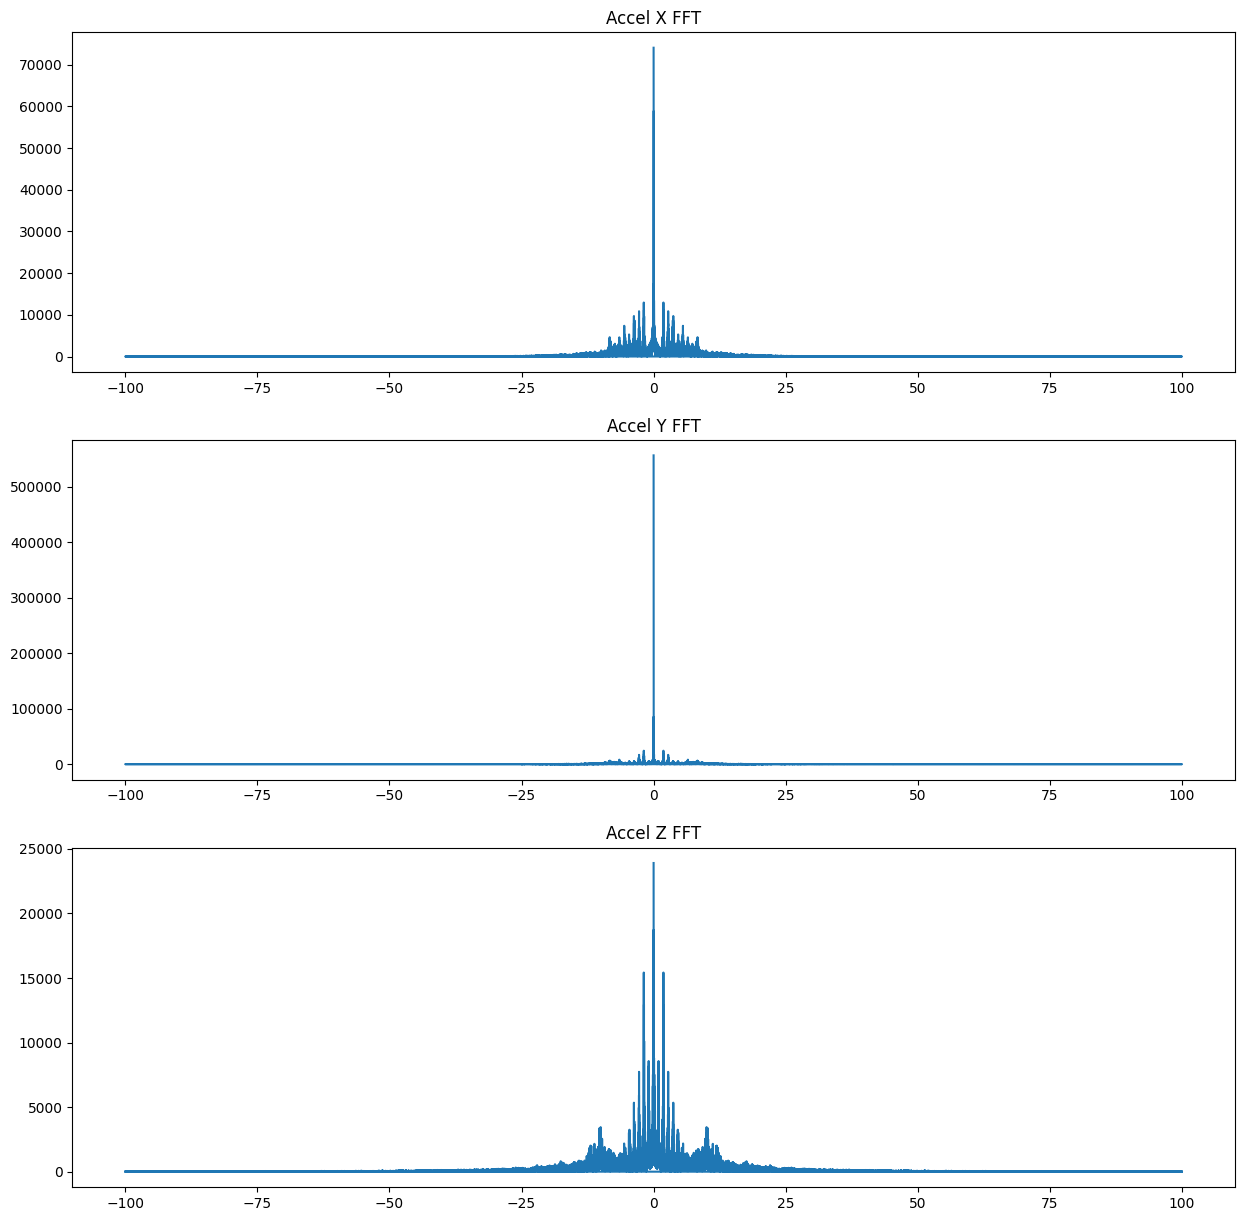

In [11]:
xf = fftfreq(accel.shape[0], 1.0 / sample_rate)

yf_x = fft(accel[:, 0])
yf_y = fft(accel[:, 1])
yf_z = fft(accel[:, 2])

fig, ax = plt.subplots(3, 1, figsize=(15, 15))
ax[0].plot(xf, np.abs(yf_x), label="fft(X)")
ax[0].set_title("Accel X FFT")
ax[1].plot(xf, np.abs(yf_y), label="fft(Y)")
ax[1].set_title("Accel Y FFT")
ax[2].plot(xf, np.abs(yf_z), label="fft(Z)")
ax[2].set_title("Accel Z FFT")
plt.show()

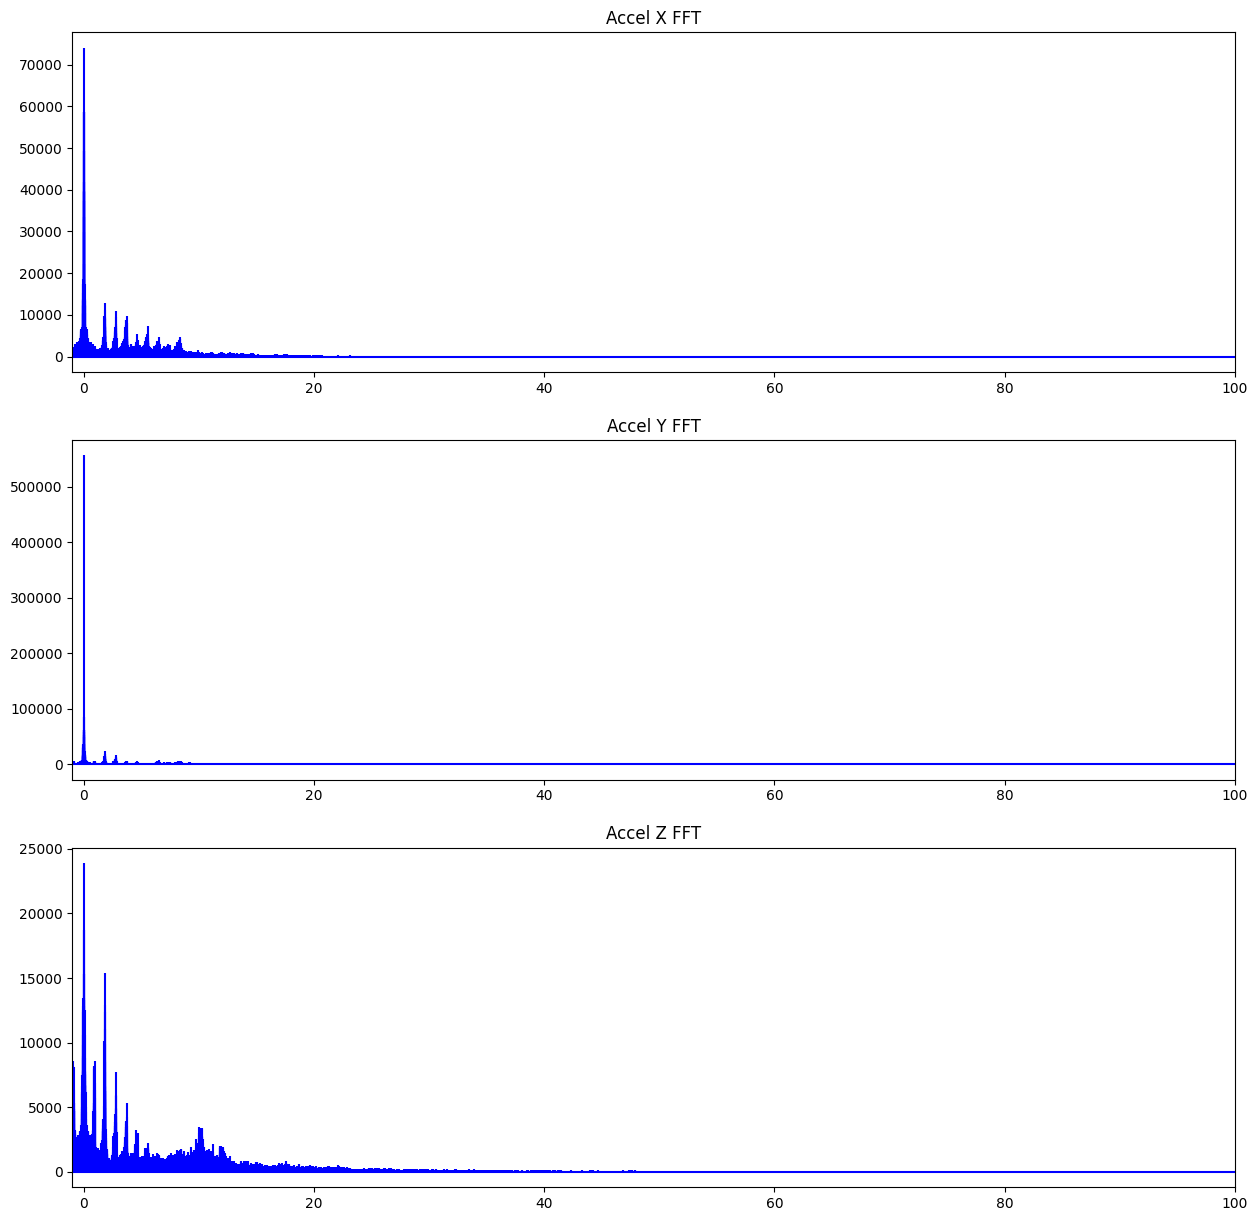

In [135]:
# Plot right side as stem plot
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
ax[0].stem(xf, np.abs(yf_x), 'b', markerfmt=" ", basefmt="-b")
ax[0].set_title("Accel X FFT")
ax[0].set_xlim(-1.0, 100)

ax[1].stem(xf, np.abs(yf_y), 'b', markerfmt=" ", basefmt="-b")
ax[1].set_title("Accel Y FFT")
ax[1].set_xlim(-1.0, 100)

ax[2].stem(xf, np.abs(yf_z), 'b', markerfmt=" ", basefmt="-b")
ax[2].set_title("Accel Z FFT")
ax[2].set_xlim(-1.0, 100)
plt.show()

L=67610 samples t::(67610,)


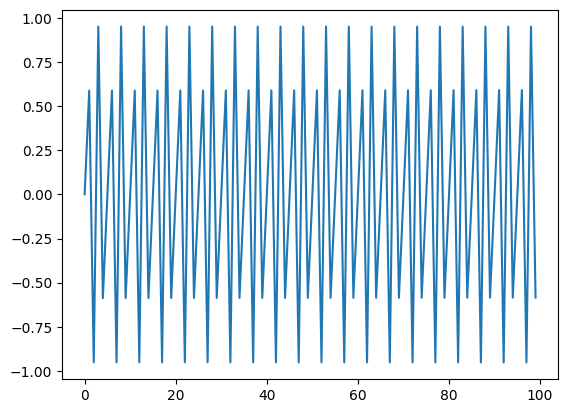

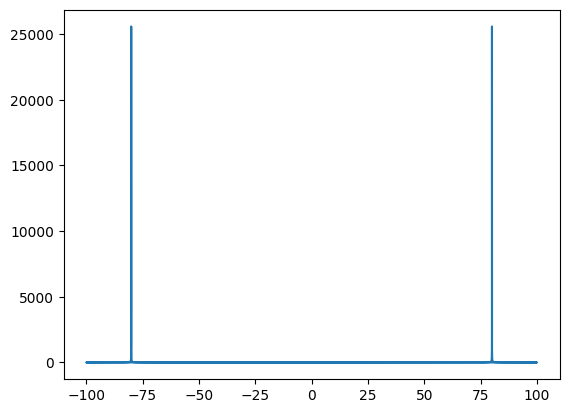

In [239]:
# Generate 80 Hz Sine Wave
Fs = sample_rate
T = 1.0/Fs
L = time.shape[0]
t = np.arange(L)
A = 1
print(f"L={L} samples t::{t.shape}")

F = 80
theta = 0

# Generate signals for x, y, z of Accel data
y = A * np.sin(2 * np.pi * F * (t / Fs) + theta)
sin_accel_x = accel_mean[0] * y
sin_accel_y = accel_mean[1] * y
sin_accel_z = accel_mean[2] * y

plt.plot(t[:100], y[:100])
plt.axis("tight")
plt.show()

# Plot frequency components
freqs = fftfreq(t.shape[0], 1/Fs)

fig, ax = plt.subplots()
plt.plot(freqs, np.abs(fft(y)))
plt.show()

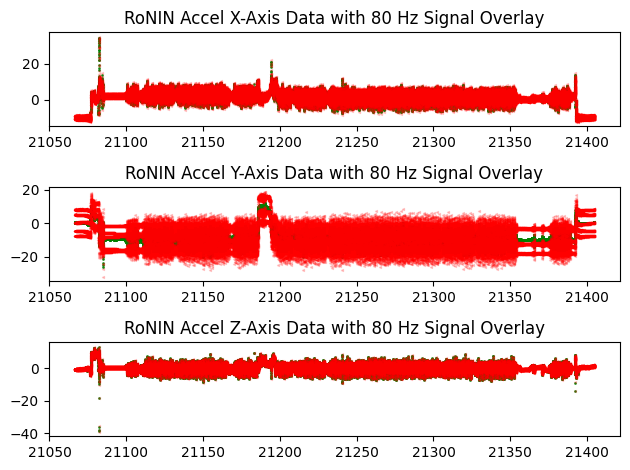

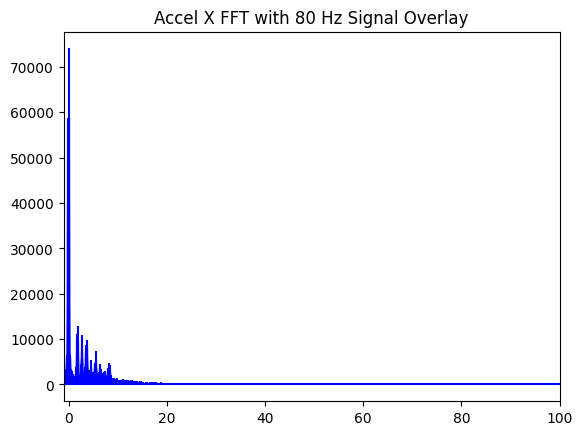

In [241]:
# Add 80Hz signal to data
accel_noised = [None, None, None]

accel_noised[0] = accel[:, 0] + sin_accel_x
accel_noised[1] = accel[:, 1] + sin_accel_y
accel_noised[2] = accel[:, 2] + sin_accel_z

fig, axes = plt.subplots(3, 1)

ax = axes[0]
ax.scatter(time, accel[:, 0], marker="o", c="g", s=1, alpha=0.8)
ax.scatter(time, accel_noised[0], marker="<", c="r", s=2, alpha=0.2)
ax.set_title("RoNIN Accel X-Axis Data with 80 Hz Signal Overlay")

ax = axes[1]
ax.scatter(time, accel[:, 1], marker="o", c="g", s=1, alpha=0.8)
ax.scatter(time, accel_noised[1], marker="<", c="r", s=2, alpha=0.2)
ax.set_title("RoNIN Accel Y-Axis Data with 80 Hz Signal Overlay")

ax = axes[2]
ax.scatter(time, accel[:, 2], marker="o", c="g", s=1, alpha=0.8)
ax.scatter(time, accel_noised[2], marker="<", c="r", s=2, alpha=0.2)
ax.set_title("RoNIN Accel Z-Axis Data with 80 Hz Signal Overlay")

fig.tight_layout()
plt.show()

xf = fftfreq(accel.shape[0], 1.0 / sample_rate)
yf_x = fft(accel[:, 0])

fig, ax = plt.subplots()
ax.stem(xf, np.abs(yf_x), 'b', markerfmt=" ", basefmt="-b")
ax.set_xlim(-1.0, 100)
ax.set_title("Accel X FFT with 80 Hz Signal Overlay")
plt.show()

Define simple similarity metrics on the datasets

* Similarity measured across dataset
* Pairwise similarity between dataframe examples
* Temporal similarity

In [81]:
# Pairwise similarity metric
